# A minimal Char RNN using TensorFlow

This Jupyter Notebook implement RNN at char level and is inspired by the _[Minimal character-level Vanilla RNN model](https://gist.github.com/karpathy/d4dee566867f8291f086)_ written by __Andrej Karpathy__

Decoding is based on [this code](https://github.com/sherjilozair/char-rnn-tensorflow) from __Sherjil Ozair__

I did some modifications to the original code to accomodate Jupyter, for instance the orginial code is splited in several files and are optimized to run using parameters from a shell command line.
I added comments, some code to test some parts line by line.

Also I've removed the ability to use LSTM or GRU and the embedings. The results are less impressive than [original code](https://github.com/sherjilozair/char-rnn-tensorflow), but closer to Karpathy's _[Minimal character-level Vanilla RNN model](https://gist.github.com/karpathy/d4dee566867f8291f086)_

Let's dive in :)

## Imports

### Import needed for Tensorflow

In [1]:
import numpy as np
import tensorflow as tf

### Import needed for Jupiter

In [2]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

### Imports needed for utilities
to load the text and transform it as a vector

In [3]:
import codecs
import os
import collections
from six.moves import cPickle
from six import text_type
import time
from __future__ import print_function

## Args, to define all parameters

The original code use __argparse__ to manage the args.

Here we define a class for it. Feel free to edit to try different settings

In [30]:
class Args():
    def __init__(self):
        '''data directory containing input.txt'''
        self.data_dir = 'data_rnn/tinyshakespeare'
        '''directory to store checkpointed models'''
        self.save_dir = 'save_vec'
        
        '''size of RNN hidden state'''
        self.rnn_size = 128
        '''minibatch size'''
        self.batch_size = 1 #was 40
        '''RNN sequence length'''
        self.seq_length = 50
        '''number of epochs'''
        self.num_epochs = 1 # was 5
        '''save frequency'''
        self.save_every = 500 # was 500
        '''Print frequency'''
        self.print_every = 100 # was 100
        '''clip gradients at this value'''
        self.grad_clip = 5.
        '''learning rate'''
        self.learning_rate = 0.002 # was ?
        '''decay rate for rmsprop'''
        self.decay_rate = 0.98 # was 0.97?
        """continue training from saved model at this path. Path must contain files saved by previous training process: 
                            'config.pkl'        : configuration;
                            'chars_vocab.pkl'   : vocabulary definitions;
                            'checkpoint'        : paths to model file(s) (created by tf).
                                                  Note: this file contains absolute paths, be careful when moving files around;
                            'model.ckpt-*'      : file(s) with model definition (created by tf)
                        """
        self.init_from = 'save_vec'
        #self.init_from = None
        
        
        '''number of characters to sample'''
        self.n = 500
        '''prime text'''
        self.prime = u' '


## Load the data

Transforming the original dataset in vector that can be use by a NN is always necessary.

This Class need to be replaced if you want to deal with other kind of data.

This class is able to cache the preprocessed data:
* Check if the data are processed allready
  * if yes load the data using Numpy (not tensorflow)
  * if not
    * process the data
    * save them using Numpy
Process the data

In [31]:
class TextLoader():
    def __init__(self, data_dir, batch_size, seq_length, encoding='utf-8'):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.seq_length = seq_length
        self.encoding = encoding

        input_file = os.path.join(data_dir, "input.txt")
        vocab_file = os.path.join(data_dir, "vocab.pkl")
        tensor_file = os.path.join(data_dir, "data.npy")

        if not (os.path.exists(vocab_file) and os.path.exists(tensor_file)):
            print("reading text file")
            self.preprocess(input_file, vocab_file, tensor_file)
        else:
            print("loading preprocessed files")
            self.load_preprocessed(vocab_file, tensor_file)
        self.create_batches()
        self.reset_batch_pointer()

    def preprocess(self, input_file, vocab_file, tensor_file):
        with codecs.open(input_file, "r", encoding=self.encoding) as f:
            data = f.read()
        counter = collections.Counter(data)
        count_pairs = sorted(counter.items(), key=lambda x: -x[1])
        self.chars, _ = zip(*count_pairs)
        self.vocab_size = len(self.chars)
        self.vocab = dict(zip(self.chars, range(len(self.chars))))
        with open(vocab_file, 'wb') as f:
            cPickle.dump(self.chars, f)
        self.tensor = np.array(list(map(self.vocab.get, data)))
        np.save(tensor_file, self.tensor)

    def load_preprocessed(self, vocab_file, tensor_file):
        with open(vocab_file, 'rb') as f:
            self.chars = cPickle.load(f)
        self.vocab_size = len(self.chars)
        self.vocab = dict(zip(self.chars, range(len(self.chars))))
        self.tensor = np.load(tensor_file)
        self.num_batches = int(self.tensor.size / (self.batch_size *
                                                   self.seq_length))

    def create_batches(self):
        self.num_batches = int(self.tensor.size / (self.batch_size *
                                                   self.seq_length))

        # When the data (tensor) is too small, let's give them a better error message
        if self.num_batches==0:
            assert False, "Not enough data. Make seq_length and batch_size small."

        self.tensor = self.tensor[:self.num_batches * self.batch_size * self.seq_length]
        xdata = self.tensor
        ydata = np.copy(self.tensor)
        ydata[:-1] = xdata[1:]
        ydata[-1] = xdata[0]
        self.x_batches = np.split(xdata.reshape(self.batch_size, -1), self.num_batches, 1)
        self.y_batches = np.split(ydata.reshape(self.batch_size, -1), self.num_batches, 1)
     
    def vectorize(self, x):
        vectorized = np.zeros((len(x), len(x[0]), self.vocab_size))
        for i in range(0, len(x)):
            for j in range(0, len(x[0])):
                vectorized[i][j][x[i][j]] = 1
        return vectorized
    
    def next_batch(self):
        x, y = self.x_batches[self.pointer], self.y_batches[self.pointer]
        self.pointer += 1
        x_vectorized = self.vectorize(x)
        y_vectorized = self.vectorize(y)
        return x_vectorized, y_vectorized

    def reset_batch_pointer(self):
        self.pointer = 0


### Let's see how preprocessing works:

In [32]:
## First we open the file
args = Args()
input_file = os.path.join(args.data_dir, "input.txt")
f =  codecs.open(input_file, "r", 'utf-8')
data = f.read()
print (data[0:300])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us


Then we have:
```python    
counter = collections.Counter(data)
count_pairs = sorted(counter.items(), key=lambda x: -x[1])
chars, _ = zip(*count_pairs)
vocab_size = len(chars)
vocab = dict(zip(chars, range(len(chars))))
```
Witch do the same than this:

```python  
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
vocab = { ch:i for i,ch in enumerate(chars) }
```

Let's see the details here:

In [33]:
counter = collections.Counter(data)
print ('histogram of char from the input data file:', counter)

histogram of char from the input data file: Counter({u' ': 169892, u'e': 94611, u't': 67009, u'o': 65798, u'a': 55507, u'h': 51310, u's': 49696, u'r': 48889, u'n': 48529, u'i': 45537, u'\n': 40000, u'l': 33339, u'd': 31358, u'u': 26584, u'm': 22243, u'y': 20448, u',': 19846, u'w': 17585, u'f': 15770, u'c': 15623, u'g': 13356, u'I': 11832, u'b': 11321, u'p': 10808, u':': 10316, u'.': 7885, u'A': 7819, u'v': 7793, u'k': 7088, u'T': 7015, u"'": 6187, u'E': 6041, u'O': 5481, u'N': 5079, u'R': 4869, u'S': 4523, u'L': 3876, u'C': 3820, u';': 3628, u'W': 3530, u'U': 3313, u'H': 3068, u'M': 2840, u'B': 2761, u'?': 2462, u'G': 2399, u'!': 2172, u'D': 2089, u'-': 1897, u'F': 1797, u'Y': 1718, u'P': 1641, u'K': 1584, u'V': 798, u'j': 628, u'q': 609, u'x': 529, u'z': 356, u'J': 320, u'Q': 231, u'Z': 198, u'X': 112, u'3': 27, u'&': 3, u'$': 1})


In [34]:
count_pairs = sorted(counter.items(), key=lambda x: -x[1])
print (count_pairs)

[(u' ', 169892), (u'e', 94611), (u't', 67009), (u'o', 65798), (u'a', 55507), (u'h', 51310), (u's', 49696), (u'r', 48889), (u'n', 48529), (u'i', 45537), (u'\n', 40000), (u'l', 33339), (u'd', 31358), (u'u', 26584), (u'm', 22243), (u'y', 20448), (u',', 19846), (u'w', 17585), (u'f', 15770), (u'c', 15623), (u'g', 13356), (u'I', 11832), (u'b', 11321), (u'p', 10808), (u':', 10316), (u'.', 7885), (u'A', 7819), (u'v', 7793), (u'k', 7088), (u'T', 7015), (u"'", 6187), (u'E', 6041), (u'O', 5481), (u'N', 5079), (u'R', 4869), (u'S', 4523), (u'L', 3876), (u'C', 3820), (u';', 3628), (u'W', 3530), (u'U', 3313), (u'H', 3068), (u'M', 2840), (u'B', 2761), (u'?', 2462), (u'G', 2399), (u'!', 2172), (u'D', 2089), (u'-', 1897), (u'F', 1797), (u'Y', 1718), (u'P', 1641), (u'K', 1584), (u'V', 798), (u'j', 628), (u'q', 609), (u'x', 529), (u'z', 356), (u'J', 320), (u'Q', 231), (u'Z', 198), (u'X', 112), (u'3', 27), (u'&', 3), (u'$', 1)]


In [35]:
chars, _ = zip(*count_pairs)
print ('chars', chars)

chars (u' ', u'e', u't', u'o', u'a', u'h', u's', u'r', u'n', u'i', u'\n', u'l', u'd', u'u', u'm', u'y', u',', u'w', u'f', u'c', u'g', u'I', u'b', u'p', u':', u'.', u'A', u'v', u'k', u'T', u"'", u'E', u'O', u'N', u'R', u'S', u'L', u'C', u';', u'W', u'U', u'H', u'M', u'B', u'?', u'G', u'!', u'D', u'-', u'F', u'Y', u'P', u'K', u'V', u'j', u'q', u'x', u'z', u'J', u'Q', u'Z', u'X', u'3', u'&', u'$')


In [36]:
vocab_size = len(chars)
print (vocab_size)

65


In [37]:
vocab = dict(zip(chars, range(len(chars))))
print (vocab)

{u'\n': 10, u'!': 46, u' ': 0, u'$': 64, u"'": 30, u'&': 63, u'-': 48, u',': 16, u'.': 25, u'3': 62, u';': 38, u':': 24, u'?': 44, u'A': 26, u'C': 37, u'B': 43, u'E': 31, u'D': 47, u'G': 45, u'F': 49, u'I': 21, u'H': 41, u'K': 52, u'J': 58, u'M': 42, u'L': 36, u'O': 32, u'N': 33, u'Q': 59, u'P': 51, u'S': 35, u'R': 34, u'U': 40, u'T': 29, u'W': 39, u'V': 53, u'Y': 50, u'X': 61, u'Z': 60, u'a': 4, u'c': 19, u'b': 22, u'e': 1, u'd': 12, u'g': 20, u'f': 18, u'i': 9, u'h': 5, u'k': 28, u'j': 54, u'm': 14, u'l': 11, u'o': 3, u'n': 8, u'q': 55, u'p': 23, u's': 6, u'r': 7, u'u': 13, u't': 2, u'w': 17, u'v': 27, u'y': 15, u'x': 56, u'z': 57}


It can be used to calculate an ID from _vocab_

In [38]:
print (vocab['a'])

4


This is equivalent of the following code by Karpathy:
it associate a unique int to any all char used in the file.

In [39]:
# Karpathy orginal code seems to do the same:
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
vocab = { ch:i for i,ch in enumerate(chars) }
print (vocab)

{u'\n': 0, u'!': 1, u' ': 2, u'$': 3, u"'": 4, u'&': 5, u'-': 6, u',': 7, u'.': 8, u'3': 9, u';': 10, u':': 11, u'?': 12, u'A': 13, u'C': 14, u'B': 15, u'E': 16, u'D': 17, u'G': 18, u'F': 19, u'I': 20, u'H': 21, u'K': 22, u'J': 23, u'M': 24, u'L': 25, u'O': 26, u'N': 27, u'Q': 28, u'P': 29, u'S': 30, u'R': 31, u'U': 32, u'T': 33, u'W': 34, u'V': 35, u'Y': 36, u'X': 37, u'Z': 38, u'a': 39, u'c': 40, u'b': 41, u'e': 42, u'd': 43, u'g': 44, u'f': 45, u'i': 46, u'h': 47, u'k': 48, u'j': 49, u'm': 50, u'l': 51, u'o': 52, u'n': 53, u'q': 54, u'p': 55, u's': 56, u'r': 57, u'u': 58, u't': 59, u'w': 60, u'v': 61, u'y': 62, u'x': 63, u'z': 64}


Now we have to make a tensor out of the data.

The tensor is done using this:
```python 
tensor = np.array(list(map(vocab.get, data)))
```

Let's split the line to see in details how it works:

In [40]:
data_in_array = map(vocab.get, data)
print (len(data_in_array))
print (data_in_array[0:200])

1115394
[19, 46, 57, 56, 59, 2, 14, 46, 59, 46, 64, 42, 53, 11, 0, 15, 42, 45, 52, 57, 42, 2, 60, 42, 2, 55, 57, 52, 40, 42, 42, 43, 2, 39, 53, 62, 2, 45, 58, 57, 59, 47, 42, 57, 7, 2, 47, 42, 39, 57, 2, 50, 42, 2, 56, 55, 42, 39, 48, 8, 0, 0, 13, 51, 51, 11, 0, 30, 55, 42, 39, 48, 7, 2, 56, 55, 42, 39, 48, 8, 0, 0, 19, 46, 57, 56, 59, 2, 14, 46, 59, 46, 64, 42, 53, 11, 0, 36, 52, 58, 2, 39, 57, 42, 2, 39, 51, 51, 2, 57, 42, 56, 52, 51, 61, 42, 43, 2, 57, 39, 59, 47, 42, 57, 2, 59, 52, 2, 43, 46, 42, 2, 59, 47, 39, 53, 2, 59, 52, 2, 45, 39, 50, 46, 56, 47, 12, 0, 0, 13, 51, 51, 11, 0, 31, 42, 56, 52, 51, 61, 42, 43, 8, 2, 57, 42, 56, 52, 51, 61, 42, 43, 8, 0, 0, 19, 46, 57, 56, 59, 2, 14, 46, 59, 46, 64, 42, 53, 11, 0, 19, 46, 57, 56, 59, 7, 2, 62, 52, 58]


In [41]:
print (data_in_array[0], 'means', data[0],'witch is the first letter in data' )

19 means F witch is the first letter in data


Then we create a numpy array out of it!

In [42]:
tensor = np.array(data_in_array)

### Let's see how batching works:

Here a reminder about the "create batches" function
```python   
def create_batches(self):
    self.num_batches = int(self.tensor.size / (self.batch_size *
                                               self.seq_length))

    # When the data (tesor) is too small, let's give them a better error message
    if self.num_batches==0:
        assert False, "Not enough data. Make seq_length and batch_size small."

    self.tensor = self.tensor[:self.num_batches * self.batch_size * self.seq_length]
    xdata = self.tensor
    ydata = np.copy(self.tensor)
    ydata[:-1] = xdata[1:]
    ydata[-1] = xdata[0]
    self.x_batches = np.split(xdata.reshape(self.batch_size, -1), self.num_batches, 1)
    self.y_batches = np.split(ydata.reshape(self.batch_size, -1), self.num_batches, 1)
```

### Let's try!

In [43]:
data_loader = TextLoader(args.data_dir, args.batch_size, args.seq_length)
data_loader.create_batches()
x, y = data_loader.next_batch()
print ('x and y are matrix ', len(x), 'x', len(x[0]) )
print ('there are', len(x), 'batch that contains', len(x[0]), 'vector that have a size of', len(x[0][0]))

loading preprocessed files
x and y are matrix  1 x 50
there are 1 batch that contains 50 vector that have a size of 65


In [44]:
print ('x[0] is the first batch of input:')
print (x[0])
print ('x[0][0] is the first char:')
print (x[0][0])
print ('y[0][0] is the first batch of expected char:')
print (y[0][0])

x[0] is the first batch of input:
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
x[0][0] is the first char:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
y[0][0] is the first batch of expected char:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [45]:
print ('y[0] is x[0] shifted by one, in other words: y[0][x] == x[0][x+1]')
print ('y[0][10] ==', y[0][10])
print ('x[0][11] ==', x[0][11])

y[0] is x[0] shifted by one, in other words: y[0][x] == x[0][x+1]
y[0][10] == [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
x[0][11] == [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


## The Model

In [46]:
class Model():
    def __init__(self, args, infer=False):
        self.args = args
        if infer:
            '''Infer is true when the model is used for sampling'''
            args.seq_length = 1
   
        hidden_size = args.rnn_size
        vocab_size = args.vocab_size
        
        # define place holder to for the input data and the target.
        self.input_data = tf.placeholder(tf.float32, [args.batch_size, args.seq_length, vocab_size], name='input_data')
        self.target_data = tf.placeholder(tf.float32, [args.batch_size, args.seq_length, vocab_size], name='target_data') 
        # define the input xs
        one_batch_input = tf.squeeze(tf.slice(self.input_data, [0, 0, 0], [1, args.seq_length, vocab_size]),[0])
        xs = tf.split(0, args.seq_length, one_batch_input)
        # define the target
        one_batch_target = tf.squeeze(tf.slice(self.target_data, [0, 0, 0], [1, args.seq_length, vocab_size]),[0])
        targets = tf.split(0, args.seq_length, one_batch_target)  
        #initial_state
        self.initial_state = tf.zeros((hidden_size,1))
        #last_state = tf.placeholder(tf.float32, (hidden_size, 1))
        
        # model parameters
        Wxh = tf.Variable(tf.random_uniform((hidden_size, vocab_size))*0.01, name='Wxh') # input to hidden
        Whh = tf.Variable(tf.random_uniform((hidden_size, hidden_size))*0.01, name='Whh') # hidden to hidden
        Why = tf.Variable(tf.random_uniform((vocab_size, hidden_size))*0.01, name='Why') # hidden to output
        bh = tf.Variable(tf.zeros((hidden_size, 1)), name='bh') # hidden bias
        by = tf.Variable(tf.zeros((vocab_size, 1)), name='by') # output bias
        loss = tf.zeros([1], name='loss')
        
        hs, ys, ps = {}, {}, {}
        
        hs[-1] = self.initial_state
        # forward pass                                                                                                                                                                              
        for t in xrange(args.seq_length):
            xs_t = tf.transpose(xs[t])
            targets_t = tf.transpose(targets[t]) 
            
            hs[t] = tf.tanh(tf.matmul(Wxh, xs_t) + tf.matmul(Whh, hs[t-1]) + bh) # hidden state
            ys[t] = tf.matmul(Why, hs[t]) + by # unnormalized log probabilities for next chars
            ps[t] = tf.exp(ys[t]) / tf.reduce_sum(tf.exp(ys[t])) # probabilities for next chars
            
            loss += -tf.log(tf.reduce_sum(tf.mul(ps[t], targets_t))) # softmax (cross-entropy loss)

        #self.probs = ps[t]
        self.cost = loss / args.batch_size / args.seq_length
        self.final_state = hs[args.seq_length-1]
        self.lr = tf.Variable(0.0, trainable=False, name='learning_rate')
        tvars = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(tf.gradients(self.cost, tvars),
                args.grad_clip)
        optimizer = tf.train.AdamOptimizer(self.lr)
        self.train_op = optimizer.apply_gradients(zip(grads, tvars))


    def sample(self, sess, chars, vocab, num=200, prime='The '):
        state = model.initial_state.eval()
        for char in prime[:-1]:
            x = np.zeros((1,1, 65))
            x[0,0, vocab[char]] = 1
            feed = {self.input_data: x, self.initial_state:state}
            [state] = sess.run([self.final_state], feed)

        def weighted_pick(weights):
            t = np.cumsum(weights)
            s = np.sum(weights)
            return(int(np.searchsorted(t, np.random.rand(1)*s)))

        ret = prime
        char = prime[-1]
        for n in range(num):
            x = np.zeros((1,1, 65))
            x[0,0, vocab[char]] = 1
            feed = {self.input_data: x, self.initial_state:state}
            [probs, state] = sess.run([self.probs, self.final_state], feed)
            #print ('p', probs.ravel())
            #print ('state', state.ravel())
            sample = weighted_pick(probs)
            #print ('sample', sample)
            pred = chars[sample]
            ret += pred
            char = pred
        return ret
    
    def inspect(self, draw=False):
        for var in tf.all_variables():
            if var in tf.trainable_variables():
                print ('t', var.name, var.eval().shape)
                if draw:
                    plt.figure(figsize=(1,1))
                    plt.figimage(var.eval())
                    plt.show()
            else:
                print ('nt', var.name, var.eval().shape)
                
        

### Inspect the model variables
Looking at the shape of use variable can help to understand the flow.  
_'t'_ as a prefix means _trainable_
_'nt'_ as a prefix means _not trainable_

In [47]:
tf.reset_default_graph()
args = Args()
data_loader = TextLoader(args.data_dir, args.batch_size, args.seq_length)
args.vocab_size = data_loader.vocab_size
print (args.vocab_size)

model = Model(args)
print ("model created")

# Open a session to inspect the model
with tf.Session() as sess:
    tf.initialize_all_variables().run()
    print('All variable initialized')
    model.inspect()
    '''
    saver = tf.train.Saver(tf.all_variables())
    ckpt = tf.train.get_checkpoint_state(args.save_dir)
    print (ckpt)
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)

        model.inspect()
        plt.figure(figsize=(1,1))
        plt.figimage(model.vectorize.eval())
        plt.show()'''

loading preprocessed files
65
model created
All variable initialized
t Wxh:0 (128, 65)
t Whh:0 (128, 128)
t Why:0 (65, 128)
t bh:0 (128, 1)
t by:0 (65, 1)
nt learning_rate:0 ()
nt beta1_power:0 ()
nt beta2_power:0 ()
nt Wxh/Adam:0 (128, 65)
nt Wxh/Adam_1:0 (128, 65)
nt Whh/Adam:0 (128, 128)
nt Whh/Adam_1:0 (128, 128)
nt Why/Adam:0 (65, 128)
nt Why/Adam_1:0 (65, 128)
nt bh/Adam:0 (128, 1)
nt bh/Adam_1:0 (128, 1)
nt by/Adam:0 (65, 1)
nt by/Adam_1:0 (65, 1)


### Visualize the graph

The following code came from the [deepdream jupyter tutorial](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb)  

It allow to draw a graph in Jupyter. It looks cool, but I'm not sure it is usefull.

In [48]:
# this code from:
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb

from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [49]:
# write the graph to help visualizing it
model_fn = 'model.pb'
tf.train.write_graph(sess.graph.as_graph_def(),'.', model_fn, as_text=False) 
    
# Visualizing the network graph. Be sure expand the "mixed" nodes to see their 
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

tmp_def = rename_nodes(graph_def, lambda s:"/".join(s.split('_',1)))
#show_graph(tmp_def)

## Trainning
### Loading the data and process them if needed

In [53]:
args = Args()

data_loader = TextLoader(args.data_dir, args.batch_size, args.seq_length)
args.vocab_size = data_loader.vocab_size

# check compatibility if training is continued from previously saved model
if args.init_from is not None:
    print ("need to load file from", args.init_from)
    # check if all necessary files exist 
    assert os.path.isdir(args.init_from)," %s must be a a path" % args.init_from
    assert os.path.isfile(os.path.join(args.init_from,"config.pkl")),"config.pkl file does not exist in path %s"%args.init_from
    assert os.path.isfile(os.path.join(args.init_from,"chars_vocab.pkl")),"chars_vocab.pkl.pkl file does not exist in path %s" % args.init_from
    ckpt = tf.train.get_checkpoint_state(args.init_from)
    assert ckpt,"No checkpoint found"
    assert ckpt.model_checkpoint_path,"No model path found in checkpoint"

    # open old config and check if models are compatible
    with open(os.path.join(args.init_from, 'config.pkl')) as f:
        saved_model_args = cPickle.load(f)
    print (saved_model_args)
    need_be_same=["model","rnn_size","seq_length"]
    for checkme in need_be_same:
        assert vars(saved_model_args)[checkme]==vars(args)[checkme],"Command line argument and saved model disagree on '%s' "%checkme

    # open saved vocab/dict and check if vocabs/dicts are compatible
    with open(os.path.join(args.init_from, 'chars_vocab.pkl')) as f:
        saved_chars, saved_vocab = cPickle.load(f)
    assert saved_chars==data_loader.chars, "Data and loaded model disagreee on character set!"
    assert saved_vocab==data_loader.vocab, "Data and loaded model disagreee on dictionary mappings!"
    print ("config loaded")

with open(os.path.join(args.save_dir, 'config.pkl'), 'wb') as f:
    cPickle.dump(args, f)
with open(os.path.join(args.save_dir, 'chars_vocab.pkl'), 'wb') as f:
    cPickle.dump((data_loader.chars, data_loader.vocab), f)


loading preprocessed files
need to load file from save_vec
<__main__.Args instance at 0x1109f0488>


KeyError: 'model'

### Instanciate the model and train it.

In [ ]:
print (args.print_every)

In [52]:
tf.reset_default_graph()
model = Model(args)
print ("model created")

cost_optimisation = []

with tf.Session() as sess:
    tf.initialize_all_variables().run()
    print ("variable initialized")
    saver = tf.train.Saver(tf.all_variables())
    # restore model
    if args.init_from is not None:
        saver.restore(sess, ckpt.model_checkpoint_path)
        print ("model restored")
    for e in range(args.num_epochs):
        sess.run(tf.assign(model.lr, args.learning_rate * (args.decay_rate ** e)))
        data_loader.reset_batch_pointer()
        state = model.initial_state.eval()
        for b in range(data_loader.num_batches):
            start = time.time()
            # Get learning data
            x, y = data_loader.next_batch()
            # Create the structure for the learning data
            feed = {model.input_data: x, model.target_data: y, model.initial_state: state}
            # Run a session using train_op
            [train_loss], state, _ = sess.run([model.cost, model.final_state, model.train_op], feed)
            end = time.time()
            if (e * data_loader.num_batches + b) % args.print_every == 0:
                cost_optimisation.append(train_loss)
                print("{}/{} (epoch {}), train_loss = {:.6f}, time/batch = {:.3f}" \
                    .format(e * data_loader.num_batches + b,
                            args.num_epochs * data_loader.num_batches,
                            e, train_loss, end - start))
            if (e * data_loader.num_batches + b) % args.save_every == 0\
                or (e==args.num_epochs-1 and b == data_loader.num_batches-1): # save for the last result
                checkpoint_path = os.path.join(args.save_dir, 'model.ckpt')
                saver.save(sess, checkpoint_path, global_step = e * data_loader.num_batches + b)
                print("model saved to {}".format(checkpoint_path))

model created
variable initialized
model restored
0/22307 (epoch 0), train_loss = 2.152187, time/batch = 0.446
model saved to save_vec/model.ckpt
100/22307 (epoch 0), train_loss = 2.011497, time/batch = 0.183
200/22307 (epoch 0), train_loss = 1.922973, time/batch = 0.181
300/22307 (epoch 0), train_loss = 2.083013, time/batch = 0.166
400/22307 (epoch 0), train_loss = 1.424449, time/batch = 0.173
500/22307 (epoch 0), train_loss = 1.849237, time/batch = 0.180
model saved to save_vec/model.ckpt
600/22307 (epoch 0), train_loss = 2.027658, time/batch = 0.167
700/22307 (epoch 0), train_loss = 1.564220, time/batch = 0.184
800/22307 (epoch 0), train_loss = 1.350735, time/batch = 0.212
900/22307 (epoch 0), train_loss = 1.986346, time/batch = 0.170
1000/22307 (epoch 0), train_loss = 1.977910, time/batch = 0.172
model saved to save_vec/model.ckpt
1100/22307 (epoch 0), train_loss = 1.676137, time/batch = 0.168
1200/22307 (epoch 0), train_loss = 2.327292, time/batch = 0.168
1300/22307 (epoch 0), tra

<IPython.core.display.Javascript object>


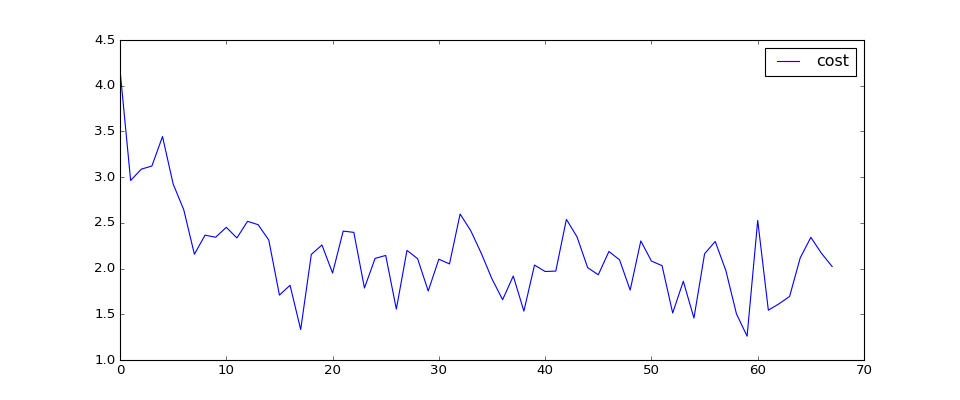

In [27]:
plt.figure(figsize=(12,5))
plt.plot(range(len(cost_optimisation)), cost_optimisation, label='cost')
plt.legend()
plt.show()

## Check Learning

model_checkpoint_path: "save_vec/model.ckpt-6500"
all_model_checkpoint_paths: "save_vec/model.ckpt-4500"
all_model_checkpoint_paths: "save_vec/model.ckpt-5000"
all_model_checkpoint_paths: "save_vec/model.ckpt-5500"
all_model_checkpoint_paths: "save_vec/model.ckpt-6000"
all_model_checkpoint_paths: "save_vec/model.ckpt-6500"

t Wxh:0 (128, 65)


<IPython.core.display.Javascript object>


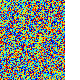

t Whh:0 (128, 128)


<IPython.core.display.Javascript object>


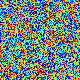

t Why:0 (65, 128)


<IPython.core.display.Javascript object>


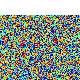

t bh:0 (128, 1)


<IPython.core.display.Javascript object>


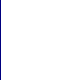

t by:0 (65, 1)


<IPython.core.display.Javascript object>


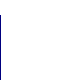

nt learning_rate:0 ()
nt beta1_power:0 ()
nt beta2_power:0 ()
nt Wxh/Adam:0 (128, 65)
nt Wxh/Adam_1:0 (128, 65)
nt Whh/Adam:0 (128, 128)
nt Whh/Adam_1:0 (128, 128)
nt Why/Adam:0 (65, 128)
nt Why/Adam_1:0 (65, 128)
nt bh/Adam:0 (128, 1)
nt bh/Adam_1:0 (128, 1)
nt by/Adam:0 (65, 1)
nt by/Adam_1:0 (65, 1)


In [28]:
tf.reset_default_graph()
model_fn = 'model.pb'

with open(os.path.join(args.save_dir, 'config.pkl'), 'rb') as f:
    saved_args = cPickle.load(f)
with open(os.path.join(args.save_dir, 'chars_vocab.pkl'), 'rb') as f:
    chars, vocab = cPickle.load(f)
    
model = Model(saved_args, True)  # True to generate the model in sampling mode
with tf.Session() as sess:
    tf.initialize_all_variables().run()
    saver = tf.train.Saver(tf.all_variables())
    ckpt = tf.train.get_checkpoint_state(args.save_dir)
    print (ckpt)
    
    model.inspect(draw=True)

### Sampling

In [29]:
with tf.Session() as sess:
    tf.initialize_all_variables().run()
    saver = tf.train.Saver(tf.all_variables())
    ckpt = tf.train.get_checkpoint_state(args.save_dir)
    print (ckpt)
    
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
        
        print(model.sample(sess, chars, vocab, args.n, args.prime))

model_checkpoint_path: "save_vec/model.ckpt-6500"
all_model_checkpoint_paths: "save_vec/model.ckpt-4500"
all_model_checkpoint_paths: "save_vec/model.ckpt-5000"
all_model_checkpoint_paths: "save_vec/model.ckpt-5500"
all_model_checkpoint_paths: "save_vec/model.ckpt-6000"
all_model_checkpoint_paths: "save_vec/model.ckpt-6500"

 this dibghamb'd bup the gando, oor, pent broth, our hantied no firs dingedpe,
My leefeak, cers werle ouk pram decturce.

KING RICHAOF I Evebstns orrenged by lick beage.
Threm ot what terpichoproad.

NONCHy
Whate good a pors,
Enstikes, of Norruenderey enf me to mears stoo,
Them by hade my'd dear.
The racthorg tham dow bus storant, the, his.

JONB:
I erold: thrord blooke ghes, dest;
Th ow thee chom hy hishaid, to this blood there bepe, and whot chim that upon beothen, be taTtoub. Muks; butcle I sh


__That's it!__

If you want to acheive better result, you can switch to LSTM with 2 layers, and add an embeding space. All of this is implemented in the [original code](https://github.com/sherjilozair/char-rnn-tensorflow)

Feedback wellcome __@dh7net__